In [1]:
!pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 8.0 MB/s eta 0:00:00


**Libraries**

In [2]:
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup
import contractions
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

**Data Frame**

In [3]:
df = pd.read_csv('Emotions_training.csv')
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


**Lower Case**

In [4]:
#converting text into lower case
df['lw_content'] = df['text'].apply(lambda x: x.lower())

**Removing Non Textual Data**

In [5]:
#removing non textual content
def remove_non_textual(text):
    return re.sub(r'[^\w\s]', '', text)
df['nt_content'] = df['lw_content'].apply(remove_non_textual)

**Removing HTML tags**

In [6]:
# to strip HTML tags
def remove_html_tags(text):
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()
df['nonhtml_text'] = df['nt_content'].apply(remove_html_tags)

In [7]:
# to expand contractions
df['ct_data'] = df['nonhtml_text'].apply(lambda x: contractions.fix(x))

**Removing Stop Words**

In [8]:
#removing stop words
stopwords.words('english')
[punc for punc in string.punctuation]
def text_process(msg):
  nopunc= [char for char in msg if char not in string.punctuation]
  nopunc= ''.join(nopunc)
  return ' '.join([word for word in nopunc.split() if word.lower() not in stopwords.words('english')])
df['cleaned_data']= df['ct_data'].apply(text_process)

**Lemmatization**

In [9]:
#lemmatizing of data
lemmatizer = WordNetLemmatizer()
def lemmatize_sentence(sentence):
    tokens = nltk.word_tokenize(sentence)
    lemmatized_sentence = ' '.join([lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tokens])
    return lemmatized_sentence
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)
df['lemmatized_text'] = df['cleaned_data'].apply(lemmatize_sentence)

df['lemmatized_text'].head()

0                                       feel humiliate
1    go feel hopeless damn hopeful around someone c...
2                   grab minute post feel greedy wrong
3    ever feel nostalgic fireplace know still property
4                                         feel grouchy
Name: lemmatized_text, dtype: object

**Vectorization(TF-IDF)**

In [10]:
def tfidf(data, column):
    vectorizer = TfidfVectorizer()
    return vectorizer.fit_transform(data[column])

tfidf_matrix = tfidf(df, 'text')


# Converting the TF-IDF matrix to an array
tfidf_matrix_array = tfidf_matrix.toarray()

# Printing the TF-IDF matrix and its shape
print("TF-IDF Matrix:")
print(tfidf_matrix_array)
print("Shape of TF-IDF matrix:", tfidf_matrix_array.shape)

TF-IDF Matrix:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Shape of TF-IDF matrix: (16000, 15186)


**Spliting dataset in to Train (70%), Test (20%) and Validation (10%) datasets**

In [11]:
train_size = int(0.7 * len(tfidf_matrix_array))
test_size = int(0.2 * len(tfidf_matrix_array))
val_size = len(tfidf_matrix_array) - train_size - test_size

# Spliting the data
train_data = tfidf_matrix_array[:train_size]
test_data = tfidf_matrix_array[train_size:train_size+test_size]
val_data = tfidf_matrix_array[train_size+test_size:]

print("Train data size:", len(train_data))
print("Test data size:", len(test_data))
print("Validation data size:", len(val_data))

Train data size: 11200
Test data size: 3200
Validation data size: 1600


In [12]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, df['label'], test_size=0.2, random_state=42)

**Multinomial Naive Bayes classifier**

In [13]:
# Training a Multinomial Naive Bayes classifier on the training data
nb_clf = MultinomialNB()
nb_clf.fit(X_train, y_train)


# Evaluating the classifier on the testing data
y_pred = nb_clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.89      0.78       946
           1       0.54      0.99      0.70      1021
           2       1.00      0.01      0.01       296
           3       0.91      0.17      0.28       427
           4       0.93      0.11      0.19       397
           5       0.00      0.00      0.00       113

    accuracy                           0.62      3200
   macro avg       0.68      0.36      0.33      3200
weighted avg       0.71      0.62      0.52      3200

[[ 844  102    0    0    0    0]
 [   9 1012    0    0    0    0]
 [  34  259    2    1    0    0]
 [ 153  201    0   72    1    0]
 [ 137  211    0    6   43    0]
 [  39   72    0    0    2    0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**SVM classifier**

In [14]:
# Training an SVM classifier on the training data
svm_clf = SVC(kernel='linear', C=1.0)
svm_clf.fit(X_train, y_train)

# Evaluating the classifier on the testing data
y_pred = svm_clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       946
           1       0.85      0.94      0.90      1021
           2       0.84      0.66      0.74       296
           3       0.91      0.85      0.88       427
           4       0.85      0.83      0.84       397
           5       0.83      0.65      0.73       113

    accuracy                           0.88      3200
   macro avg       0.86      0.81      0.83      3200
weighted avg       0.88      0.88      0.87      3200

[[877  25   8  17  16   3]
 [ 21 964  25   4   5   2]
 [  6  86 195   5   4   0]
 [ 25  23   1 365  12   1]
 [ 24  21   2  12 329   9]
 [  6  10   1   0  23  73]]


**Random Forest Classifier and XGBClassifier**

In [15]:
# Training an RandomForest Classifier on the training data
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_clf.fit(X_train, y_train)

# Evaluating the classifier on the testing data
y_pred = rf_clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# Training an XGBoost Classifier on the training data
gbm_clf = xgb.XGBClassifier(objective='multi:softmax', num_class=3, max_depth=6, learning_rate=0.1, n_estimators=100)
gbm_clf.fit(X_train, y_train)

# Evaluating the classifier on the testing data
y_pred = gbm_clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.80      0.00      0.01       946
           1       0.32      1.00      0.48      1021
           2       0.00      0.00      0.00       296
           3       0.00      0.00      0.00       427
           4       0.00      0.00      0.00       397
           5       0.00      0.00      0.00       113

    accuracy                           0.32      3200
   macro avg       0.19      0.17      0.08      3200
weighted avg       0.34      0.32      0.16      3200

[[   4  942    0    0    0    0]
 [   0 1021    0    0    0    0]
 [   0  296    0    0    0    0]
 [   1  426    0    0    0    0]
 [   0  397    0    0    0    0]
 [   0  113    0    0    0    0]]
              precision    recall  f1-score   support

           0       0.94      0.85      0.89       946
           1       0.75      0.94      0.83      1021
           2       0.82      0.70      0.76       296
           3       0.90      0.77      0.

**Hyperparameter tuning(MultinomialNB)**

In [16]:
#training data for hyperparameter tuning(MultinomialNB)
nb_clf = MultinomialNB()
param_grid = {'alpha': [0.1, 1, 10]}
grid_search = GridSearchCV(nb_clf, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)
print("Best parameters for Multinomial Naive Bayes:", grid_search.best_params_)
y_pred = grid_search.predict(X_test)
print("Classification report for Multinomial Naive Bayes:\n", classification_report(y_test, y_pred))
print("Confusion matrix for Multinomial Naive Bayes:\n", confusion_matrix(y_test, y_pred))

Best parameters for Multinomial Naive Bayes: {'alpha': 0.1}
Classification report for Multinomial Naive Bayes:
               precision    recall  f1-score   support

           0       0.73      0.90      0.81       946
           1       0.70      0.93      0.80      1021
           2       0.81      0.29      0.43       296
           3       0.85      0.60      0.71       427
           4       0.81      0.52      0.63       397
           5       0.73      0.10      0.17       113

    accuracy                           0.74      3200
   macro avg       0.77      0.56      0.59      3200
weighted avg       0.75      0.74      0.71      3200

Confusion matrix for Multinomial Naive Bayes:
 [[854  61   6  16   8   1]
 [ 50 948  10   6   5   2]
 [ 42 158  86   5   5   0]
 [ 94  59   0 257  17   0]
 [ 91  78   3  18 206   1]
 [ 41  48   1   0  12  11]]


**Hyperparameter tuning(RandomForestClassifier)**

In [17]:
rf_clf = RandomForestClassifier(random_state=42)
param_grid = {'n_estimators': [10, 50, 100], 'max_depth': [5, 10, 15]}
grid_search = GridSearchCV(rf_clf, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)
print("Best parameters for Random Forest:", grid_search.best_params_)
y_pred = grid_search.predict(X_test)
print("Classification report for Random Forest:\n", classification_report(y_test, y_pred))
print("Confusion matrix for Random Forest:\n", confusion_matrix(y_test, y_pred))

Best parameters for Random Forest: {'max_depth': 15, 'n_estimators': 10}
Classification report for Random Forest:
               precision    recall  f1-score   support

           0       0.85      0.25      0.39       946
           1       0.36      0.98      0.53      1021
           2       0.79      0.04      0.07       296
           3       0.93      0.20      0.33       427
           4       0.98      0.11      0.20       397
           5       0.92      0.10      0.18       113

    accuracy                           0.44      3200
   macro avg       0.80      0.28      0.28      3200
weighted avg       0.72      0.44      0.37      3200

Confusion matrix for Random Forest:
 [[ 240  702    0    3    1    0]
 [  17 1001    1    1    0    1]
 [   9  275   11    1    0    0]
 [  11  331    0   85    0    0]
 [   6  343    2    1   45    0]
 [   1  101    0    0    0   11]]


**Hyperparameter tuning(SVM Classifier)**

In [18]:
#training data for hyperparameter tuning
X_train_subset = X_train[:1000]
y_train_subset = y_train[:1000]

svm_clf = SVC(kernel='linear', gamma=0.1)


param_grid = {'C': [0.1, 1, 10]}

grid_search = GridSearchCV(svm_clf, param_grid, cv=2, scoring='accuracy')
grid_search.fit(X_train_subset, y_train_subset)

print("Best parameters for SVM:", grid_search.best_params_)

svm_best = SVC(kernel='linear', gamma=0.1, C=grid_search.best_params_['C'])
svm_best.fit(X_train, y_train)

y_pred = svm_best.predict(X_test)

print("Classification report for SVM:\n", classification_report(y_test, y_pred))
print("Confusion matrix for SVM:\n", confusion_matrix(y_test, y_pred))

Best parameters for SVM: {'C': 10}
Classification report for SVM:
               precision    recall  f1-score   support

           0       0.88      0.91      0.90       946
           1       0.85      0.91      0.88      1021
           2       0.80      0.69      0.74       296
           3       0.88      0.85      0.86       427
           4       0.84      0.79      0.82       397
           5       0.75      0.61      0.67       113

    accuracy                           0.86      3200
   macro avg       0.84      0.79      0.81      3200
weighted avg       0.86      0.86      0.85      3200

Confusion matrix for SVM:
 [[860  39   9  21  13   4]
 [ 40 933  34   5   6   3]
 [ 11  74 204   3   4   0]
 [ 29  18   3 361  14   2]
 [ 23  25   3  18 314  14]
 [  9  12   1   0  22  69]]


**Hyperparameter tuning(XGBOOST Classifier)**

In [19]:
X_train_subset = X_train[:1000]
y_train_subset = y_train[:1000]

xgb_clf = xgb.XGBClassifier(objective='multi:softmax', num_class=3, max_depth=10, random_state=42)

param_dist = {'learning_rate': [0.1, 0.01, 0.001], 'n_estimators': [10, 50, 100]}

random_search = RandomizedSearchCV(xgb_clf, param_dist, cv=2, scoring='accuracy', n_iter=5)
random_search.fit(X_train_subset, y_train_subset)

print("Best parameters for XGBoost:", random_search.best_params_)

xgb_best = xgb.XGBClassifier(objective='multi:softmax', num_class=3, max_depth=10, learning_rate=random_search.best_params_['learning_rate'], n_estimators=random_search.best_params_['n_estimators'], random_state=42)
xgb_best.fit(X_train, y_train)

y_pred = xgb_best.predict(X_test)

print("Classification report for XGBoost:\n", classification_report(y_test, y_pred))
print("Confusion matrix for XGBoost:\n", confusion_matrix(y_test, y_pred))

Best parameters for XGBoost: {'n_estimators': 50, 'learning_rate': 0.1}
Classification report for XGBoost:
               precision    recall  f1-score   support

           0       0.94      0.83      0.88       946
           1       0.73      0.93      0.82      1021
           2       0.81      0.70      0.75       296
           3       0.90      0.74      0.81       427
           4       0.88      0.73      0.80       397
           5       0.74      0.85      0.79       113

    accuracy                           0.83      3200
   macro avg       0.83      0.80      0.81      3200
weighted avg       0.84      0.83      0.83      3200

Confusion matrix for XGBoost:
 [[782 125   7  15  12   5]
 [ 16 954  36   4   6   5]
 [  3  80 207   4   1   1]
 [ 24  76   2 314   9   2]
 [ 11  64   3  10 288  21]
 [  0   6   0   0  11  96]]


**Final Model Selection**

In [25]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
def evaluate_final_model(model, X_train, y_train, X_test, y_test, X_val, y_val):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_val_pred = model.predict(X_val)
    print(model)
    print("Final Model Performance on Training Set:")
    print(classification_report(y_train, y_train_pred))
    print("Final Model Performance on Test Set:")
    print(classification_report(y_test, y_test_pred))
    print("Final Model Performance on Validation Set:")
    print(classification_report(y_val, y_val_pred))

nb_clf.fit(X_train, y_train)

xgb_clf.fit(X_train, y_train)

svm_best.fit(X_train, y_train)

svm_clf.fit(X_train, y_train)

# Choosing the best performing model
evaluate_final_model(svm_clf, X_train, y_train, X_test, y_test, X_val, y_val)
evaluate_final_model(xgb_clf, X_train, y_train, X_test, y_test, X_val, y_val)
evaluate_final_model(xgb_best, X_train, y_train, X_test, y_test, X_val, y_val)

SVC(gamma=0.1, kernel='linear')
Final Model Performance on Training Set:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1203
           1       0.96      0.99      0.97      1413
           2       0.99      0.88      0.93       341
           3       0.98      0.95      0.97       582
           4       0.96      0.97      0.97       509
           5       1.00      0.89      0.94       145

    accuracy                           0.97      4193
   macro avg       0.98      0.94      0.96      4193
weighted avg       0.97      0.97      0.97      4193

Final Model Performance on Test Set:
              precision    recall  f1-score   support

           0       0.81      0.88      0.84       946
           1       0.72      0.95      0.82      1021
           2       0.89      0.46      0.61       296
           3       0.90      0.70      0.79       427
           4       0.84      0.65      0.73       397
           5       0.9

**Plotting**

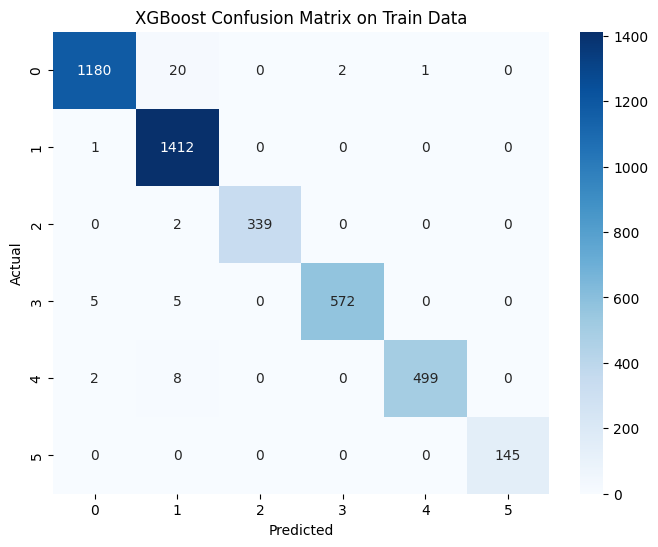

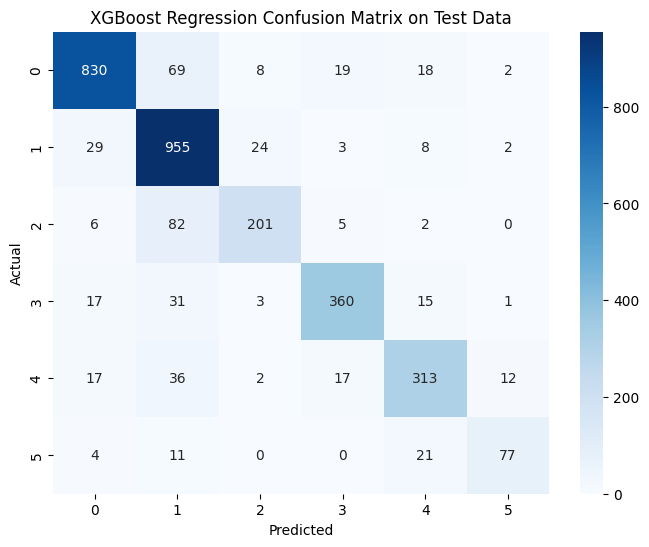

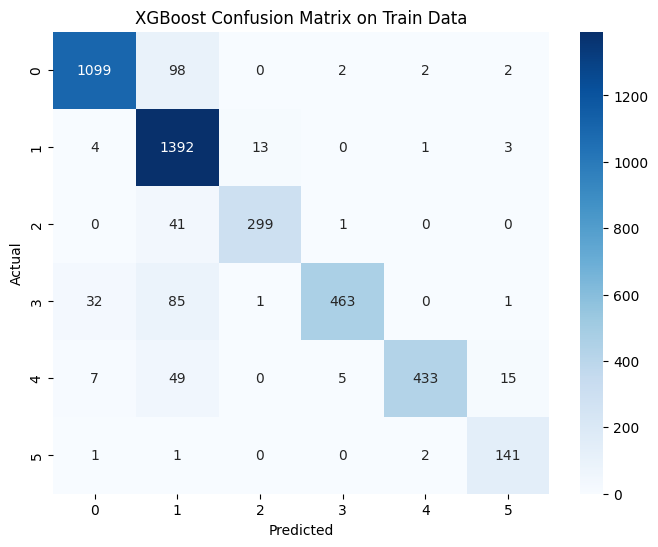

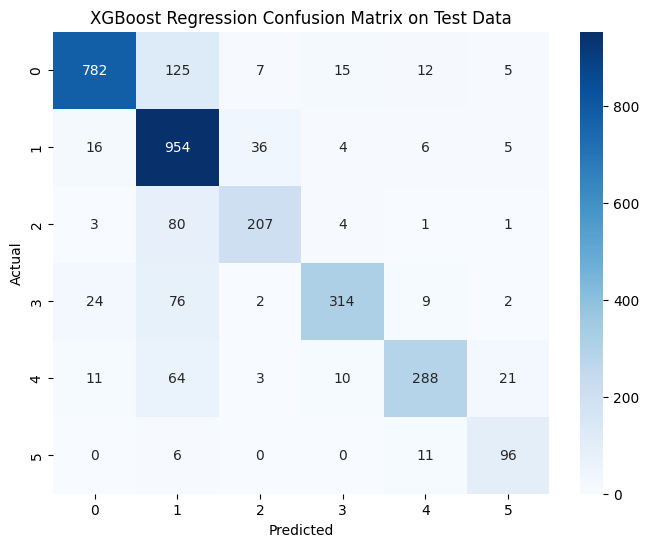

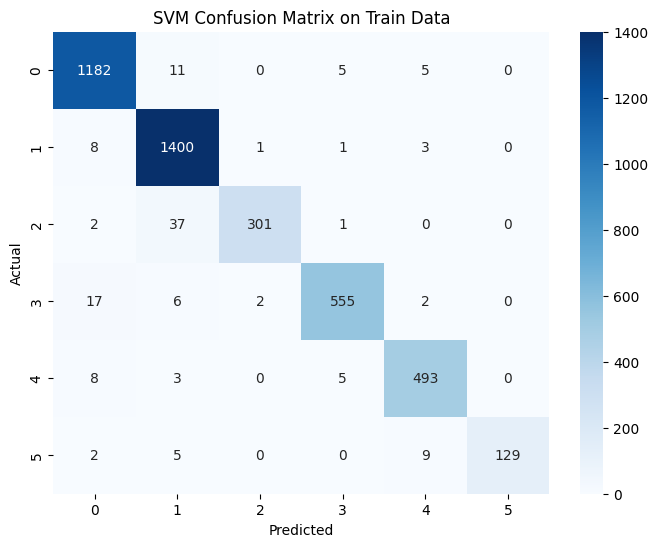

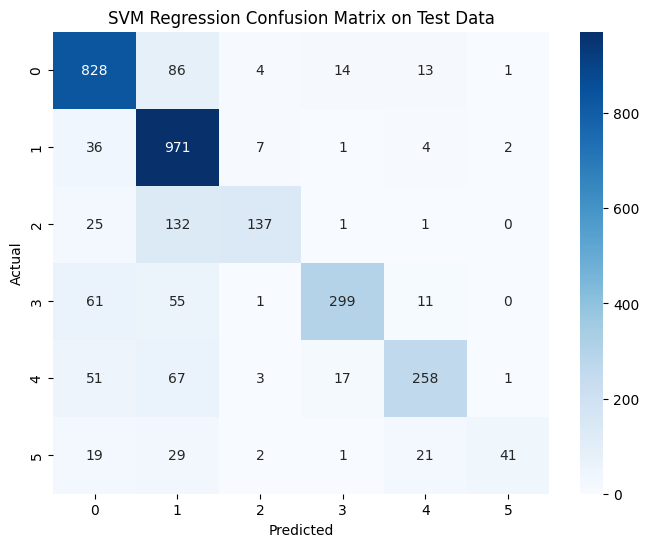

In [26]:
def plot(model, title, y_true, X_true):
    y_pred = model.predict(X_true)
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

plot(xgb_clf, "XGBoost Confusion Matrix on Train Data", y_train, X_train)
plot(xgb_clf, "XGBoost Regression Confusion Matrix on Test Data", y_test, X_test)

plot(xgb_best, "XGBoost Confusion Matrix on Train Data", y_train, X_train)
plot(xgb_best, "XGBoost Regression Confusion Matrix on Test Data", y_test, X_test)

plot(svm_clf, "SVM Confusion Matrix on Train Data", y_train, X_train)
plot(svm_clf, "SVM Regression Confusion Matrix on Test Data", y_test, X_test)